In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/obulisainaren/multi-cancer/README.md


In [3]:
import os

for dirname, _, _ in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/datasets
/kaggle/input/datasets/obulisainaren
/kaggle/input/datasets/obulisainaren/multi-cancer
/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer
/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer
/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer
/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer/cervix_koc
/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer/cervix_dyk
/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer/cervix_pab
/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer/cervix_sfi
/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer/cervix_mep
/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer
/kaggle/input/datasets/obulisain

In [4]:
from torchvision import datasets, transforms

data_dir = "/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

print(dataset.classes)

['brain_glioma', 'brain_menin', 'brain_tumor']


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [21]:
data_dir = "/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer"

In [22]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [23]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

print("Classes:", dataset.classes)
print("Total Images:", len(dataset))

Classes: ['brain_glioma', 'brain_menin', 'brain_tumor']
Total Images: 15000


In [36]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [37]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [39]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


In [47]:
for param in model.parameters():
    param.requires_grad = False

In [49]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

In [50]:
model = model.to(device)

In [51]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [53]:
epochs = 20

for epoch in range(epochs):

    model.train()
    running_loss = 0

    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print("Epoch:", epoch+1, "Loss:", running_loss)

Epoch: 1 Loss: 48.99098365753889
Epoch: 2 Loss: 45.15251719765365
Epoch: 3 Loss: 44.98101030290127
Epoch: 4 Loss: 46.42514196643606
Epoch: 5 Loss: 42.551631899084896
Epoch: 6 Loss: 42.62985133891925
Epoch: 7 Loss: 43.12360119167715
Epoch: 8 Loss: 43.086652437224984
Epoch: 9 Loss: 41.327737221028656
Epoch: 10 Loss: 40.69464475940913
Epoch: 11 Loss: 43.60101968469098
Epoch: 12 Loss: 42.19265458872542
Epoch: 13 Loss: 40.148873397149146
Epoch: 14 Loss: 41.04236084478907
Epoch: 15 Loss: 40.06119727157056
Epoch: 16 Loss: 40.52191885141656
Epoch: 17 Loss: 39.37179273273796
Epoch: 18 Loss: 40.07226968253963
Epoch: 19 Loss: 40.45880676386878
Epoch: 20 Loss: 38.46712334500626


In [54]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import time

In [55]:
model.eval()

all_preds = []
all_labels = []
all_probs = []

start_test = time.time()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

end_test = time.time()

test_time = end_test - start_test
print("Testing time:", test_time)

Testing time: 20.46728277206421


In [56]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy:", accuracy)

Accuracy: 0.9686666666666667


In [57]:
cm = confusion_matrix(all_labels, all_preds)

class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, acc in enumerate(class_accuracy):
    print(f"Class {i} Accuracy: {acc}")

Class 0 Accuracy: 0.9807692307692307
Class 1 Accuracy: 0.9482926829268292
Class 2 Accuracy: 0.977710233029382


In [58]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       988
           1       0.97      0.95      0.96      1025
           2       0.96      0.98      0.97       987

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



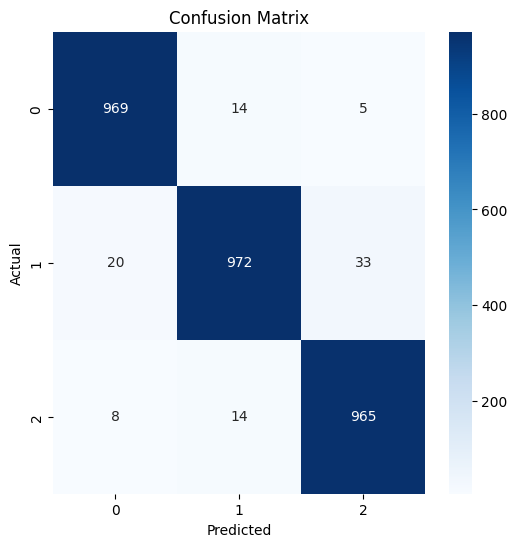

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [60]:
from sklearn.preprocessing import label_binarize

n_classes = len(dataset.classes)

labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))
probs = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

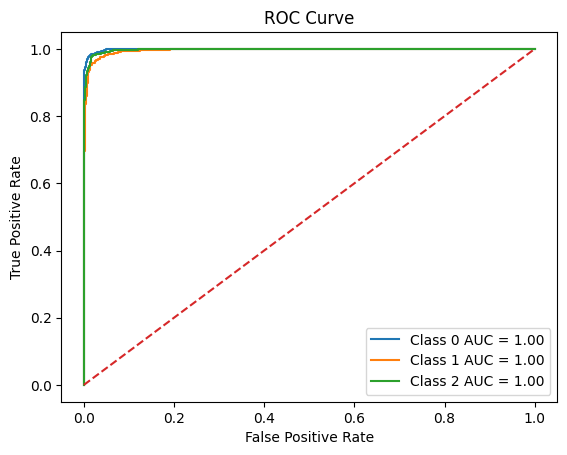

In [61]:
plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [62]:
start_train = time.time()

# training loop here

end_train = time.time()

train_time = end_train - start_train
print("Training time:", train_time)

Training time: 5.1021575927734375e-05


In [66]:
time_per_epoch = 120  # example seconds
training_time = time_per_epoch * 20
print(training_time)

2400


In [67]:
seconds = 2400

minutes = seconds / 60

print(f"Training Time: {minutes:.2f} minutes")

Training Time: 40.00 minutes
